## Primeira versão Auto-pytorch - entendimento da biblioteca
- https://github.com/automl/Auto-PyTorch
- https://www.automl.org/automl-for-x/tabular-data/autopytorch/
- https://automl.github.io/Auto-PyTorch/development/
- https://automl.github.io/Auto-PyTorch/development/manual.html

# Esse notebook foi rodado dentro do .devcontainer para a imagem automlorg/autopytorch:v0.2 que foi pega do docker hub

## Comandos necessarios para rodar o AutoPytorch
Esses comandos já foram adicionados no dev container

In [ ]:
# ! apt-get update

In [ ]:
# !apt-get install libgl1-mesa-glx -y

In [19]:
# Rodar esse comando no terminal, nao no notebook 
# ! apt-get install libglib2.0-0 -y
# dpkg --configure -a  # Isso 

In [ ]:
# Opcional
# apt-get install htop

## Importar as bibliotecas

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../auto-pytorch') 

In [3]:
import os
import pandas as pd
from glob import glob
import tempfile as tmp
from joblib import Parallel, delayed
from autoPyTorch.api.tabular_classification import TabularClassificationTask


## Leitura dos dados
Metodologia da Fernanda e da Ana:
- Os dados de julho e agosto de 2024 foram usados para o treinamento, os dados de setembro sao os dados de teste
- E só usamos os "manufacturer" ST12000NM0008 e ST12000NM001G ?!
- As meninas usaram penas as features abaixo:<br>
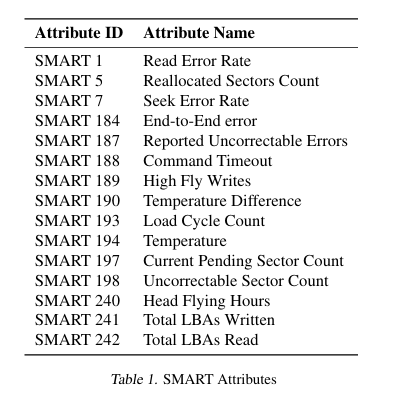


In [4]:
MODELS_TO_USE = ['ST12000NM0008', 'ST12000NM001G']
COLUMNS_TO_USE = [
    "date", "failure",
    "smart_1_normalized", "smart_5_normalized", "smart_7_normalized",  "smart_184_normalized",
    "smart_187_normalized", "smart_188_normalized", "smart_189_normalized", "smart_190_normalized",
    "smart_193_normalized", "smart_194_normalized", "smart_197_normalized", "smart_198_normalized",
    "smart_240_normalized", "smart_241_normalized", "smart_242_normalized"
]

In [5]:
def read_and_preprocess_data(csv_path):
    """Reads the data and preprocesses it"""
    df = pd.read_csv(csv_path, low_memory=False)
    df = df.loc[df.model.isin(MODELS_TO_USE)]
    df = df.loc[:, COLUMNS_TO_USE]
    df['date'] = pd.to_datetime(df['date'])
    return df

In [7]:
csv_paths = (
    glob("../Data/*/*/*.csv")
    # glob("../Data/data_Q3_2024/data_Q3_2024/*.csv")
    # + glob("../Data/data_Q2_2024/data_Q2_2024/*.csv")
    )

In [ ]:
processed_dfs = Parallel(n_jobs=10, verbose=10)(
    delayed(read_and_preprocess_data)(csv_path) for csv_path in csv_paths
)

In [8]:
dataframe = pd.concat(processed_dfs, ignore_index=True)

In [9]:
# dataframe.to_parquet("data_processed.parquet")

In [ ]:
dataframe.shape

In [ ]:
21_189_746

## Separa os dados do treinamento / validacao e teste
Os dados de julho e agosto de 2024 foram usados para o treinamento, os dados de setembro sao os dados de teste

In [6]:
dataframe = pd.read_parquet("data_processed.parquet")

In [7]:
dataframe.shape

(21189746, 17)

In [8]:
# train_date = '2024-07-01'
validation_date = '2024-08-01'
test_date = '2024-09-01'

train_dataframe = dataframe[
    # (dataframe.date >= train_date) & (dataframe.date < validation_date)
    (dataframe.date < validation_date)
].reset_index(drop=True)

validation_dataframe = dataframe[
    (dataframe.date >= validation_date) & (dataframe.date < test_date)
].reset_index(drop=True)

test_dataframe = dataframe[dataframe.date >= test_date].reset_index(drop=True)

In [9]:
del dataframe

In [10]:
print("Soma de falhas train_dataframe", train_dataframe.failure.sum())
print("train_dataframe porcentagem de falhas", train_dataframe.failure.sum() / len(train_dataframe))
print()

print("Soma de falhas validation_dataframe", validation_dataframe.failure.sum())
print("validation_dataframe porcentagem de falhas", validation_dataframe.failure.sum() / len(validation_dataframe))
print()

print("Soma de falhas test_dataframe", test_dataframe.failure.sum())
print("test_dataframe porcentagem de falhas", test_dataframe.failure.sum() / len(test_dataframe))

Soma de falhas train_dataframe 1126
train_dataframe porcentagem de falhas 5.861162490267399e-05

Soma de falhas validation_dataframe 56
validation_dataframe porcentagem de falhas 5.566788539572908e-05

Soma de falhas test_dataframe 55
test_dataframe porcentagem de falhas 5.655096681589267e-05


In [11]:
print("train_dataframe len:", len(train_dataframe))
print("validation_dataframe len:", len(validation_dataframe))
print("test_dataframe len:", len(test_dataframe))

train_dataframe len: 19211206
validation_dataframe len: 1005966
test_dataframe len: 972574


## Fazendo o undersampling dos dados de treino

In [12]:
train_dataframe = pd.concat(
    [train_dataframe.query("failure == 1"),
     train_dataframe.query("failure == 0").sample(100_000, random_state=12_01_2001)], 
    ignore_index=True
)

# Treinamento do modelo

In [13]:
X_COLUMNS = [
    "smart_1_normalized", "smart_5_normalized", "smart_7_normalized",  "smart_184_normalized",
    "smart_187_normalized", "smart_188_normalized", "smart_189_normalized", "smart_190_normalized",
    "smart_193_normalized", "smart_194_normalized", "smart_197_normalized", "smart_198_normalized",
    "smart_240_normalized", "smart_241_normalized", "smart_242_normalized"
]
Y_COLUMN = "failure"

In [14]:
os.environ['JOBLIB_TEMP_FOLDER'] = tmp.gettempdir()
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

In [15]:
# ! rm -r "temporary_directory_auto_pytorch_versao_4"
# ! rm -r "output_directory_auto_pytorch_versao_4"

In [16]:
# Lista de metricas possiveis
# additional_metrics: ['precision', 'accuracy', 'balanced_accuracy', 'roc_auc', 'average_precision', 'log_loss',
# 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted',
# 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted']

In [17]:
api = TabularClassificationTask(
    n_jobs=6,
    n_threads=5,
    seed=12_01_2001,
    temporary_directory="temporary_directory_auto_pytorch_versao_4",
    output_directory="output_directory_auto_pytorch_versao_4",
    delete_tmp_folder_after_terminate=False,
)

In [18]:
api.search(
    X_train=train_dataframe[X_COLUMNS],
    y_train=train_dataframe[Y_COLUMN],
    X_test=validation_dataframe[X_COLUMNS],
    y_test=validation_dataframe[Y_COLUMN],
    dataset_name='Trabalho_final_deep_learning_versao_4',
    optimize_metric='precision',
    total_walltime_limit=60*60*6,
    # func_eval_time_limit_secs=60*60*2,
    portfolio_selection="greedy",
    memory_limit=1024*48,
    enable_traditional_pipeline=False,
)

/usr/local/lib/python3.8/dist-packages/autoPyTorch/data/tabular_feature_validator.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = pd.to_numeric(X[column])
/usr/local/lib/python3.8/dist-packages/autoPyTorch/data/tabular_feature_validator.py:251: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = pd.to_numeric(X[column])
/usr/local/lib/python3.8/dist-packages/autoPyTorch/data/tabular_feature_validator.py:251: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

[WARNING] [2025-01-27 06:36:00,367:Client-AutoPyTorch:Trabalho_final_deep_learning_versao_4:12012001] Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (21590.000000)
[WARNING] [2025-01-27 06:36:00,369:Client-AutoPyTorch:Trabalho_final_deep_learning_versao_4:12012001] Capping the func_eval_time_limit_secs to 10795 to have time for a least 2 models to ensemble.


/usr/local/lib/python3.8/dist-packages/autoPyTorch/optimizer/utils.py:28: UserWarning: Failed to convert {'data_loader:batch_size': 60, 'encoder:__choice__': 'OneHotEncoder', 'coalescer:__choice__': 'NoCoalescer', 'feature_preprocessor:__choice__': 'NoFeaturePreprocessor', 'imputer:numerical_strategy': 'mean', 'lr_scheduler:__choice__': 'CosineAnnealingLR', 'network_backbone:__choice__': 'ShapedMLPBackbone', 'network_embedding:__choice__': 'NoEmbedding', 'network_head:__choice__': 'fully_connected', 'network_init:__choice__': 'XavierInit', 'optimizer:__choice__': 'AdamOptimizer', 'scaler:__choice__': 'StandardScaler', 'trainer:__choice__': 'MixUpTrainer', 'lr_scheduler:CosineAnnealingLR:T_max': 50, 'network_backbone:ShapedMLPBackbone:activation': 'relu', 'network_backbone:ShapedMLPBackbone:max_units': 290, 'network_backbone:ShapedMLPBackbone:mlp_shape': 'funnel', 'network_backbone:ShapedMLPBackbone:num_groups': 6, 'network_backbone:ShapedMLPBackbone:output_dim': 200, 'network_backbone:

[ERROR] [2025-01-27 12:36:04,176:asyncio.events] 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/distributed/utils.py", line 799, in wrapper
    return await func(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packages/distributed/client.py", line 1246, in _reconnect
    await self._ensure_connected(timeout=timeout)
  File "/usr/local/lib/python3.8/dist-packages/distributed/client.py", line 1276, in _ensure_connected
    comm = await connect(
  File "/usr/local/lib/python3.8/dist-packages/distributed/comm/core.py", line 315, in connect
    await asyncio.sleep(backoff)
  File "/usr/lib/python3.8/asyncio/tasks.py", line 659, in sleep
    return await future
asyncio.exceptions.CancelledError
[ERROR] [2025-01-27 12:36:04,188:asyncio.events] 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/distributed/utils.py", line 799, in wrapper
    return await func(*args, **kwargs)
  File "/usr/local/lib/python3.8/dist-packag

In [19]:
import pickle

In [20]:
with open('estimator_versao_4.pickle', 'wb') as handle:
    pickle.dump(api, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
print(api.show_models())

|    | Preprocessing                                                             | Estimator                                                       |   Weight |
|---:|:--------------------------------------------------------------------------|:----------------------------------------------------------------|---------:|
|  0 | SimpleImputer,Variance Threshold,NoCoalescer,NoEncoder,RobustScaler,SRC   | no embedding,ShapedMLPBackbone,FullyConnectedHead,nn.Sequential |     0.78 |
|  1 | SimpleImputer,Variance Threshold,NoCoalescer,NoEncoder,Normalizer,FastICA | no embedding,MLPBackbone,FullyConnectedHead,nn.Sequential       |     0.22 |


In [22]:
print(api.sprint_statistics())

autoPyTorch results:
	Dataset name: Trabalho_final_deep_learning_versao_4
	Optimisation Metric: precision
	Best validation score: 0.6309859154929578
	Number of target algorithm runs: 27
	Number of successful target algorithm runs: 10
	Number of crashed target algorithm runs: 5
	Number of target algorithms that exceeded the time limit: 10
	Number of target algorithms that exceeded the memory limit: 2



In [ ]:
with open('estimator_versao_4.pickle', 'rb') as handle:
    estimator = pickle.load(handle)

## Metricas nos dados de teste

In [23]:
y_test_predict = api.predict(test_dataframe[X_COLUMNS], n_jobs=32)

/usr/local/lib/python3.8/dist-packages/autoPyTorch/data/tabular_feature_validator.py:251: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = pd.to_numeric(X[column])


In [ ]:
# y_test_predict_2 = estimator.predict(test_dataframe[X_COLUMNS], n_jobs=32)

In [ ]:
# all(y_test_predict == y_test_predict_2)

In [24]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

In [25]:
f1_score_test_metric = f1_score(test_dataframe[Y_COLUMN], y_test_predict)
print("f1_score_test_metric: ", f1_score_test_metric)
accuracy_score_test_metric = accuracy_score(test_dataframe[Y_COLUMN], y_test_predict)
print("accuracy_score_test_metric: ", accuracy_score_test_metric)
precision_score_test_metric = precision_score(test_dataframe[Y_COLUMN], y_test_predict)
print("precision_score_test_metric: ", precision_score_test_metric)
recall_score_test_metric = recall_score(test_dataframe[Y_COLUMN], y_test_predict)
print("recall_score_test_metric: ", recall_score_test_metric)
roc_auc_score_test_metric = roc_auc_score(test_dataframe[Y_COLUMN], y_test_predict)
print("roc_auc_score_test_metric: ", roc_auc_score_test_metric)

f1_score_test_metric:  0.009092334221664836
accuracy_score_test_metric:  0.993500751613759
precision_score_test_metric:  0.004585705249841872
recall_score_test_metric:  0.5272727272727272
roc_auc_score_test_metric:  0.7603999230115532
